# Running Spatial Correlations + options
The goal of this log is to show the API of the spatial correlations and the options available.
With this code, it is possible to run the spatial correlations on masked and unmasked data.

Also, it is possible to apply a correction, 
    I call symmetric averaging, which is a 
    derivative of a method by Schatzel (1988):
    
    
Schätzel, Klaus, Martin Drewel, and Sven Stimac. "Photon correlation measurements at large lag times: improving statistical accuracy." Journal of Modern Optics 35.4 (1988): 711-718.


Julien Lhermitte, jan 2017

The correlation function in 1 dimension is:
$$C = \frac{1}{N(k)} \sum \limits_j^{N_t} I_j I_{j+k} M_j M_{j+k}$$
We may normalize it by its average intensity in two different ways:

## 1. Naive averaging:

the normalized correlation function is just divided by the average squared:
$$cc_{reg} = \frac{CC}{\bar{I}^2}$$
where:
$$\bar{I} = \frac{1}{N(k)} \sum \limits_{j=1}^{N_t} I_j$$
is average intensity
and where $$N(k) = \sum \limits_{j= 1}^{N_t}M_j M_{j+k}$$
(Note that in the limit of no mask, $N(k) = N_t$ as it should, mask has effect of inducing a $k$ dependence on the effective ''$N_t$'')


## 2. Symmetric Averaging:

For symmetric averaging, we define two new averages, $I_p$ and $I_f$ (I 'past' and I 'future'):
$$I_p = \frac{1}{N(k)} \sum \limits_j I_j M_j M_{j+k}$$
$$I_f = \frac{1}{N(k)} \sum \limits_l I_{l+k} M_l M_{l+k}$$
we define symmetric averaging as:
$$cc_{sym} = \frac{CC}{\bar{I}_p \bar{I}_p}$$


Schatzel shows this averaging is superior for the case of a simple ''mask'' : a 1D time series (data outside of time range is ''masked'')

I'm happy to provide my derivation/example for the motivation of symmetric averaging.

In [22]:
# import libraries

# %load ../pyscripts/0937-test-spatialcorrelator.py
%matplotlib inline
import numpy as np
from pyCXD.tools.CrossCorrelator import CrossCorrelator
import matplotlib.pyplot as plt
from skbeam.core.roi import ring_edges, segmented_rings


# for some convolutions, used to smooth images (make spatially correlated images)
def convol2d(a,b=None,axes=(-2,-1)):
    ''' convolve a and b along axes axes
        if axes 1 element, then convolves along that dimension
        only works with dimensions 1 or 2 (1 or 2 axes)
    '''
    from numpy.fft import fft2, ifft2
    if(b is None):
        b = a
    return ifft2(fft2(a,axes=axes)*np.conj(fft2(b,axes=axes)),axes=axes).real

In [2]:
#this test is just meant to show an example
# for a test for nosetests, reduce number points to something manageable like 10-50
# random seed for reproducibility
np.random.seed(123)

# 1. Try on 1D data

In [3]:
# test 1D data
sigma = .1
Npoints = 1000
x = np.linspace(-10, 10, Npoints)
y = convol2d(np.random.random(Npoints)*10, np.exp(-x**2/(2*sigma**2)),axes=(-1,))

mask_1D = np.ones_like(y)
mask_1D[10:20] = 0
mask_1D[60:90] = 0
mask_1D[111:137] = 0
mask_1D[211:237] = 0
mask_1D[411:537] = 0

mask_1D *= mask_1D[::-1]

y_masked = y*mask_1D

cc1D = CrossCorrelator(mask_1D.shape)
cc1D_symavg = CrossCorrelator(mask_1D.shape,normalization='symavg')
cc1D_masked = CrossCorrelator(mask_1D.shape,mask=mask_1D)
cc1D_masked_symavg = CrossCorrelator(mask_1D.shape, mask=mask_1D,normalization='symavg')

ycorr_1D = cc1D(y)
ycorr_1D_masked = cc1D_masked(y*mask_1D)
ycorr_1D_symavg = cc1D_symavg(y)
ycorr_1D_masked_symavg = cc1D_masked_symavg(y*mask_1D)


## Plot the data

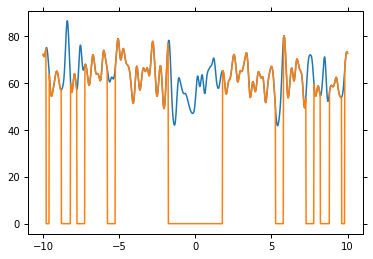

In [20]:
# plot 1D Data
plt.figure(0);plt.clf();
plt.plot(x,y)
plt.plot(x,y*mask_1D)

## Correlations for different cases

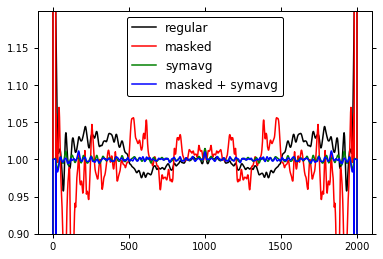

In [5]:
plt.figure(1);plt.clf();
plt.plot(ycorr_1D,color='k',label='regular')
plt.plot(ycorr_1D_masked,color='r',label='masked')
plt.plot(ycorr_1D_symavg,color='g',label='symavg')
plt.plot(ycorr_1D_masked_symavg,color='b',label='masked + symavg')
plt.ylim(.9,1.2)
plt.legend()

# 2. Try for 2D data
(In this case, even no mask has a strong effect on data. No mask still contains a ''mask'' since at higher correlation lengths we are correlating less points. Symmetric averaging excels to overcome these effects here.)

In [43]:
# test 2D data
Npoints2 = 100
x2 = np.linspace(-10, 10, Npoints2)
X, Y = np.meshgrid(x2,x2)
Z = np.random.random((Npoints2,Npoints2))
Z = convol2d(Z, np.exp(-(X**2 + Y**2)/2./sigma**2))

mask_2D = np.ones_like(Z)
mask_2D[10:20, 10:20] = 0
mask_2D[73:91, 45:67] = 0
mask_2D[1:20, 90:] = 0

cc2D = CrossCorrelator(mask_2D.shape)
cc2D_symavg = CrossCorrelator(mask_2D.shape,normalization='symavg')
cc2D_masked = CrossCorrelator(mask_2D.shape,mask=mask_2D)
cc2D_masked_symavg = CrossCorrelator(mask_2D.shape, mask=mask_2D,normalization='symavg')

ycorr_2D = cc2D(Z)
ycorr_2D_masked = cc2D_masked(Z*mask_2D)
ycorr_2D_symavg = cc2D_symavg(Z)
ycorr_2D_masked_symavg = cc2D_masked_symavg(Z*mask_2D)

## plot 2D data

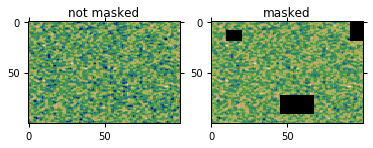

In [44]:
plt.figure(2);plt.clf();
plt.subplot(2,2,1)
plt.title("not masked")
plt.imshow(Z)

plt.subplot(2,2,2)
plt.title("masked")
plt.imshow(Z*mask_2D)

## Correlations (2D)

(130, 70)

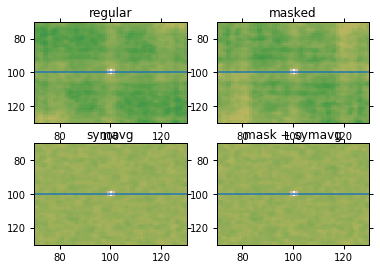

In [45]:
vmin=.95; vmax=1.03

plt.figure(3);plt.clf();
plt.subplot(2,2,1)
plt.title("regular")
plt.imshow(ycorr_2D)
plt.axhline(ycorr_2D_masked.shape[0]//2)
plt.clim(vmin,vmax)
plt.xlim(70,130)
plt.ylim(130,70)
plt.subplot(2,2,2)
plt.title("masked")
plt.imshow(ycorr_2D_masked)
plt.axhline(ycorr_2D_masked.shape[0]//2)
plt.clim(vmin,vmax)
plt.xlim(70,130)
plt.ylim(130,70)
plt.subplot(2,2,3)
plt.title("symavg")
plt.imshow(ycorr_2D_symavg)
plt.axhline(ycorr_2D_masked.shape[0]//2)
plt.clim(vmin,vmax)
plt.xlim(70,130)
plt.ylim(130,70)
plt.subplot(2,2,4)
plt.title("mask + symavg")
plt.imshow(ycorr_2D_masked_symavg)
plt.axhline(ycorr_2D_masked.shape[0]//2)
plt.clim(vmin,vmax)
plt.xlim(70,130)
plt.ylim(130,70)


## Correlation Cross sections

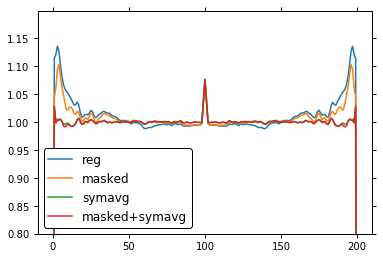

In [46]:
plt.figure(4);plt.clf();
plt.plot(ycorr_2D[ycorr_2D.shape[0]//2],label="reg")
plt.plot(ycorr_2D_masked[ycorr_2D_masked.shape[0]//2],label="masked")
plt.plot(ycorr_2D_symavg[ycorr_2D_symavg.shape[0]//2],label="symavg")
plt.plot(ycorr_2D_masked_symavg[ycorr_2D_masked_symavg.shape[0]//2],label="masked+symavg")
plt.ylim(0.8, 1.2)
plt.legend()

# 3. Try with different id's in different regions of image

In [51]:
# make id numbers
edges = ring_edges(1, 20, num_rings=2)
segments = 5
x0, y0 = np.array(mask_2D.shape)//2
maskids = segmented_rings(edges,segments,(y0,x0),mask_2D.shape)

cc2D_ids = CrossCorrelator(mask_2D.shape, mask=maskids)
cc2D_ids_symavg = CrossCorrelator(mask_2D.shape,mask=maskids,normalization='symavg')

ycorr_ids_2D = cc2D_ids(Z)
ycorr_ids_2D_symavg = cc2D_ids_symavg(Z)

## Plot mask

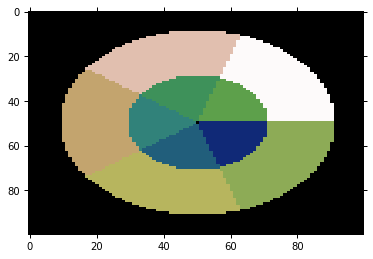

In [52]:
plt.figure(2);plt.clf();
plt.imshow(maskids)


## plot correlations
Here, we see that without symmetric averaging, the correlations quickly come back at values higher than the point of initial correlation, whereas with symmetric averaging, the result looks more as what is expected, a nice Gaussian like curve centered in image. (Center of image is zero correlation)

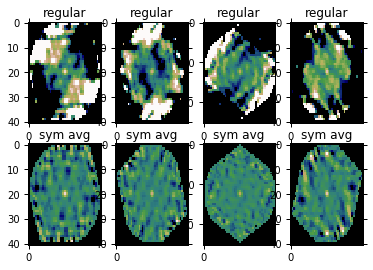

In [61]:
vmin=.95; vmax=1.1

fig, axes = plt.subplots(2,4)
ax1 = axes[:len(axes)//2].ravel()
ax2 = axes[len(axes)//2:].ravel()

for i in range(len(ax1)):
    plt.sca(ax1[i])
    plt.title("regular")
    plt.imshow(ycorr_ids_2D[i])
    plt.clim(vmin,vmax)
    
    plt.sca(ax2[i])
    plt.title("sym avg")
    plt.imshow(ycorr_ids_2D_symavg[i])
    plt.clim(vmin,vmax)

## Correlation cross sections